# Análise de Sentimentos Comparativa para Português

**Daniel Pimentel Kansaon**

**Matrícula: 2018718007**

**daniel.kansaon@dcc.ufmg.br**

O crescimento das plataformas de E-Commerce na Web motivou um grande aumento das compras online, gerando clientes cada vez mais exigentes que utilizam sites de revisões, blogs e redes sociais para avaliações e tomada de decisão. De maneira geral, clientes utilizam essas informações como uma maneira de confirmar seu interesse em um produto, decidindo se de fato irão comprar ou não e até mesmo para descobrir opções mais vantajosas. Nessas plataformas, um formato comum de avaliação é a comparação, onde clientes comparam características de um produto com outro, exemplo: "O celular X **é melhor do que** o Y". 

As sentenças comparativas podem ser classificadas em dois principais tipos:
           
- Comparações Metalinguísticas: Comparam propriedades de uma mesma entidade. Por exemplo: "Este carro é  mais **potente do que** econômico."
        
- Comparações Propositais: Realizam comparações entre duas proposições.      
    - Comparações Nominais: Comparam a cardinalidade de duas entidades. Exemplo: "José **tem mais** motos **do que** carros."
    - Comparações Qualitativas: Essas comparações geralmente levam palavras como: melhor, mais, etc. Exemplo: "Pepsi é **melhor do que** Coca-Cola."

    - Comparações Adverbiais: São semelhantes as comparações nominais e qualitativas, a diferença é que ocorrem após um verbo. Exemplo: "Bolt corre **mais rápido do que** Vanderlei."
               
        
Com isso, o trabalho busca classificar sentenças entre (comparativas ou não) aplicando métodos de aprendizado de máquina focando no português brasileiro.

Ao todo foram aplicados 4 algoritmos: Regressão Logística, LSTM, LSTM Bidirecional, CNN.

# Bibliotecas

Abaixo segue os imports que foram utilizados no trabalho. Para execução dos algoritmos utilizou-se a biblioteca Keras.

In [1]:
import re
import os
import codecs
import emoji
import numpy as np
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn import metrics

#Keras
import statistics
from keras import optimizers
from keras import regularizers
from keras import layers
from keras.models import Sequential
from keras.models import load_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import LSTM, Bidirectional
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import RepeatVector
from keras.layers import Permute
from keras.layers import Lambda
from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D
from keras import backend as K

#Processamento Texto
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.core import*

#Cross Validation
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline


#Gráfico
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model

# Remove os alertas retornados pelo TensorFlow
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

def printmd(s):
    display(Markdown(s))

Using TensorFlow backend.


# 1 - Constantes

Nesta etapa definimos as constantes, ou seja, as informações que serão utilizadas durante todo o trabalho.

## 1.1 - Modelos

In [2]:
PATH_DIR_DATA = "data" # PASTA QUE CONTÊM OS DADOS COLETADOS

SIZE_MAX_WORDS_SENTENCES = 300 #TAMANHO MAXIMO DE PALAVRAS EM UMA SENTENÇA

DIMENSION_WORD_EMBEDDING = 300 # DIMENSÃO DO EMBEDDING UTILIZADO

SIZE_VOCAB = 5000 #QUANTIDADE DE PALAVRAS QUE SERÃO TRABALHADAS NO VOCABULARIO

K_FOLD = 5 #NÚMERO DE FOLDS UTILIZADO PARA A VALIDAÇÃO CRUZADA

N_CLASS = 2 # QUANTIDADE DE CLASSES QUE EXISTEM (0 - NÃO COMPARATIVA; 1 - COMPARATIVA)

## 1.2 - Dados

As constantes abaixo dizem sobre a coleta dos dados. As **KEYWORDS** foram utilizados como critério na busca, bem como as **ENTIDADES**. Já **DIC_CONTRACTIONS** foi utilizado na parte do processamento dos dados, onde substituiu-se as contrações por seu formato correto.

In [3]:
# ENTIDADES UTLIZADAS PARA COLETAR TWEETS 
ENTIDADES = ["samsung", "apple", "coca cola", "guarana", "brahma"] 

# NOME DO ARQUIVO QUE POSSUI TWEETS COLETADOS SEM O USO DE ENTIDADES
FILE_SEM_ENTIDADE = "keywords"

# KEYWORDS QUE INDICAM A EXISTENCIA DE SENTENCAS COMPARATIVAS
KEYWORDS = [
    "mais",
    "melhor",
    "superior",
    "bom",
    "ruim",
    "pior",
    "inferior",
    "péssimo",
    "maior",
    "menor",
    "menos",
    "ótimo",
    "maravilhoso",
    "maravilhosa",
    "gostoso",
    "excelente"
]

#PRINCIPAIS CONTRAÇÕES EXISTENTES NO PORTUGUES-BR
DIC_CONTRACTIONS = { 
        " q ":" que ",
        " eh ":" é ",
        " mto ":" muito ",
        " mt ": " muito ",
        " ces ": " vocês ",
        " tb ": " também ",
        " vdd ": " verdade ",
        " tá ": " está ",
        " ta ": " está ",
        " n ": " não ",
        " ñ ": " não ",
        " vc ": " você ",
        " tdo ": " tudo ",
        " td ": " tudo ",
    }

# 2 - Coleta dos Dados no Twitter

Abaixo estão os códigos relacionados com a coleta dos dados. Para a obtenção dos dados, foi utilizado a API do Twitter através da biblioteca tweepy. A metodologia utilizada para a coleta baseou-se em duas principais variáveis. A primeira é a **KEYWORDS**, que são palavras-chave que podem indicar a existência de comparação, ou seja, funciona como um bom filtro das sentenças. Essa abordagem tem um alto recall mas uma precisão baixa. Isso ocorre porque das sentenças filtradas pelas palavras-chave quase todas as comparativas estão ali presentes mas muitas sentenças não comparativas também são filtradas. Além disto, foi utilizado variável utilizada foi a **ENTIDADES**, que foca em buscar tweets que estejam falando de algum produto ou empresa, assim é possível obter textos mais específicos facilitando a etapa de rotulação dos dados. Após toda a coleta, os tweets foram rotulados manualmente sendo que 1 indica comparativo e 0 não comparativo.

Em resumo, foram realizadas duas coletas, onde na primeira foram obtidos tweets que possuem alguma das palavras existentes nas **ENTIDADES** e **KEYWORDS**. Já na segunda obteve tweets que apenas contenham apenas as **KEYWORDS**, possibilitando a obtenção de exemplos mais variados.

As Keywods foram obtidas através do trabalho "(Jindal, N. & Liu, B. (2006)) Identifying Comparative Sentences in Text Documents" que pode ser acessado em: https://www.cs.uic.edu/~liub/publications/sigir06-comp.pdf. Os autores disponibilizaram uma lista de palavras que podem indicar a existência de comparações. Esta lista foi traduzida e utilizada no trabalho.

In [4]:
# Salva os tweets coletados em arquivos .txt
def write_file(name, tweets):   
    filename = os.path.join("data/{}.txt".format(name))
    
    if os.path.exists(filename):
        append_write = 'a' 
    else:
        append_write = 'w+'

    file = codecs.open(filename, append_write, "utf-8")    
    count = 0
    
    for t in tweets:
        count = count + 1
        line = str(count) + ", " + t.full_text
        file.writelines(line + "\n")

    file.close()    

#Coleta os tweets através das palavras chaves
def coletct_tweets(generic=False):    
    new_tweets = []
    
    #Faz autenticação para acessar a API do Twitter
    auth = tweepy.OAuthHandler(API_KEY, API_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
    api = tweepy.API(auth)

    #Realiza a busca do tweets com base nas ENTIDADES definidas
    for en in ENTIDADES:
        for es in KEYWORDS:
            new_tweets.extend(api.search(q='"' + es +'"' + en, lang="pt", tweet_mode='extended')) #Entidade           
        
        write_file(en, new_tweets)
        new_tweets = []
        
    #Busca apenas as palavras chaves SEM as ENTIDADES
    if(generic):
        for es in KEYWORDS:
            new_tweets.extend(api.search(q='"' + es +'"', lang="pt", tweet_mode='extended')) #Sem sentidade
            
        write_file(FILE_SEM_ENTIDADE, new_tweets)

# 3 - Métodos Comuns

Abaixo estão os métodos que serão utilizados por todo o trabalho.

#### Método que carrega os dados (tweets) coletados para um dicionário

O dicionário possui a estrutura {"texto":0, "texto":1}

In [5]:
def load_data():
    dic = {}    
    v_files = ENTIDADES
    v_files.append(FILE_SEM_ENTIDADE)
    
    for en in v_files:
        filename = os.path.join("./{}/".format(PATH_DIR_DATA) + en + ".txt")
        file = codecs.open(filename, "r", "utf-8")
        lines = file.readlines()    

        text = ''
        count = 1

        for l in lines:        
            text += l
            text = text.replace(str(count) + ', ', '', 1)
           
            if ", 0" in text:
                dic.update({text.replace(', 0', ''): 0})
                text = ''                  
                count += 1          
            elif ", 1" in text:
                dic.update({text.replace(', 1', ''): 1})
                text = ''
                count += 1   
                
        file.close()

    return dic

#### Método para remover contrações dos textos

Uma das etapas de processamento foi o ajuste das contrações. Dessa forma, os métodos abaixo são responsáveis pela tarefa.

In [6]:
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(DIC_CONTRACTIONS)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

#### Método que processa os tweets removendo partes irrelevantes para a classificação

O método abaixo dado os textos coletados, remove:
- Links
- Marcas de agregação (menções, hashtags, etc)
- Emojis
- Contrações
- Stop Words
- Entidades utilizadas na busca

Como foi utilizado **ENTIDADES** para a coleta, observou-se que os modelos estavam dando uma maior importância para essas palavras para a classificação. Como existem muitas sentenças comparativas com a palavra Coca-Cola, o modelo associou a palavra com uma alta possibilidade de ser comparativa. Dessa forma, foi necessário a remoção destas entidades nas sentenças.

In [7]:
def clear_text(dic_data):
    X = []
    Y = []
  
    for text, label in dic_data.items():
        #Twitter Markers
        text = re.sub(r"(?:\@|https?\://)\S+", "", text)#Links and mentions
        text = "".join(x for x in text if x != "?") #markes interrogation
        text = "".join(x for x in text if x != "!") #markes exclamation
        text = re.sub(r'\d+', '', text) #numbers
        
        #Individuals caracteres
        text = text.replace('\n', ' ').replace('\r', ' ').replace('RT', '')
        text = re.sub("'", '', text)
        text = re.sub("\"", '', text)
        text = re.sub("“", '', text)
        text = re.sub("”", '', text)
        text = re.sub("%", '', text)  

        #Emoji
        text = emoji.get_emoji_regexp().sub(u'', text) 
                
        #Contractions
        text = replace_contractions(text)
        
        #Stop Words
        stop_words = set(stopwords.words('portuguese')) 
        word_list = text_to_word_sequence(text)
        no_stop_words = [w for w in word_list if not w in stop_words]
        text = " ".join(no_stop_words)
        
        #Remove keywords used in data collection
        for ent in ENTIDADES:
            text = text.replace(ent,"")
        
        X.append(text.strip().lower())
        Y.append(label)
    
    return X, Y

#### Método que tokeniza os textos

As redes neurais não recebem o texto bruto de fato, com isso é necessário que os textos sejam tokenizados. Nesta etapa cada palavra do vocabulário recebe um index. Assim, as palavras de cada sentença são substituídas por seu respectivo index. Além disto, foi utilizado o que chamamos de padding. Sabe-se que as redes precisam sempre receber sentenças do mesmo tamanho, com isso, as sentenças são completadas com zero para que fiquem sempre com o mesmo tamanho.

In [8]:
def prepare_data(texts):
    tokenizer = Tokenizer(num_words = SIZE_VOCAB, split=' ')    
    #Obtêm os tokens das palavras
    tokenizer.fit_on_texts(texts)    
    #Tokeniza os textos
    x = tokenizer.texts_to_sequences(texts)
    #Completa a sentenças com 0 até o tamanho máximo
    x = pad_sequences(x, maxlen = SIZE_MAX_WORDS_SENTENCES) 
    #Obtêm os indices das palavras tokenizadas
    word_index = tokenizer.word_index
    
    return x, word_index, tokenizer

#### Método que plota o gráfico de acurácia 

Já os métodos abaixo são responsáveis por plotar os gráficos utilizados no trabalho.

In [11]:
def plot_acc(history):
    # Gera graficos do resultado do treino
    plt.rc("font", **{"size": 14})
    fig, axes = plt.subplots(1, 2, figsize=(15, 3))

    # Loss
    axes[0].plot(range(1, len(history.history["loss"])+1), history.history["loss"], 
    label="Train Loss", color="royalblue", lw=3)
    axes[0].plot(range(1, len(history.history["val_loss"])+1), history.history["val_loss"], 
    label="Test Loss", color="forestgreen", lw=3)
    axes[0].set_ylabel("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_xticks(range(1, len(history.history["acc"])+1))
    axes[0].set_ylim(bottom=0)
    axes[0].legend()

    # Accuracy
    axes[1].plot(range(1, len(history.history["acc"])+1), history.history["acc"], 
    label="Train ACC", color="royalblue", lw=3)
    axes[1].plot(range(1, len(history.history["val_acc"])+1), history.history["val_acc"], 
    label="Teste ACC", color="forestgreen", lw=3)
    axes[1].set_ylabel("Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_xticks(range(1, len(history.history["acc"])+1))
    axes[1].legend()
    axes[1].set_ylim(bottom=0)
    plt.show()

#### Calcula intervalo de confianca de 95%

Este método calcula o intervalo de confiança dado um vetor de resultados. O intervalo considera 4 graus de liberdade e 95% de confiança na tabela T-Student.

In [12]:
def calc_conf_interval(v_validation):
    tbl_t_95 = 2.77 #Valor na tabela T-Student (4 graus de liberdade)
    mean = np.mean(v_validation, dtype=np.float64)
    std = np.std(v_validation)
        
    return [mean, (mean - (tbl_t_95 * std)), (mean + (tbl_t_95 * std)), tbl_t_95 * std]

# 4 - Preparação do Word Embedding

Como a tarefa se trata do idioma português, não existe um embedding pronto para utilização em Python. Dessa forma, foi necessário fazer download de um embedding em outro lugar.

Assim foi obtido o embedding do trabalho desenvolvido em 2017 http://nilc.icmc.usp.br/embeddings, que disponibilizou vários word embeddings previamente treinados em 17 base de dados diferentes.

O modelo utilizado no trabalho foi o Word2Vec de 300 dimensões com Skip-Gram, pode ser baixado no link: http://143.107.183.175:22980/download.php?file=embeddings/word2vec/skip_s300.zip. No trabalho foi testado outros embeddings de 50, 100 e 300 dimensões. Escolheu-se um embedding com 300 dimensões pois apresentou os melhores resultados.

O método abaixo cria a matriz de embedding que será utilizada na camada de embedding das redes neurais. Cada linha da matriz possui as palavras do vocabulário, já as colunas são as dimensões do embedding, no caso 300. Exemplo da matriz abaixo:

       DIM1|    DIM2|    DIM3..|    DIM300
WORD1

WORD2

WORD3

In [13]:
def load_word_embedding(word_index, number_words, dimension_embedding):
    dic_embedding = {}
    
    file_embedding = open(os.path.join('./files_embedding', "skip_s{}.txt".format(dimension_embedding)), encoding='utf-8')
    
    #Carregando os WordEmbeddings para um dicionario
    for line in tqdm(file_embedding):
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefficient = np.asarray(values[1:], dtype='float32')
        dic_embedding[word] = coefficient
            
    file_embedding.close()
    
    #Cria a matrix com em que serão carregados os embeddings
    matrix_embedding = np.zeros((number_words, dimension_embedding))
    
    for word, i in word_index.items():
        if i >= SIZE_VOCAB:
            continue
        
        vector_embedding = dic_embedding.get(word)
        
        if vector_embedding is not None:
            matrix_embedding[i] = vector_embedding

    return matrix_embedding




# 5 - Carregando os Dados

Após todos os métodos apresentados, esta seção carrega, processa e divide os dados para aplicação dos métodos de machine learning de fato.

In [14]:
#Carrega os dados coletados para um dicionario
dic_data = load_data()

#Processa os tweets removendo informações desnecessárias
texts_words, y_class = clear_text(dic_data)

#Imprime quantidade de sentenças em cada classe
print("Dados\n")
qtd_comparativa = list(filter(lambda x: y_class[x] == 1, range(len(y_class))))
print("Qtd Comparativa: {}".format(len(qtd_comparativa)))
print("Qtd Não Comparativa: {}".format(len(y_class) - len(qtd_comparativa)))

#Transforma os tweets em vetores que possuem apenas o indice da palavra
x_text, word_index, tokenizer = prepare_data(texts_words)

#Transforma os rótulos [0,1,1,1,0,1,0,1] em one-hot-encoder[[0,1],[1,0]], que é aceito pela rede
y_class = to_categorical(y_class, num_classes=N_CLASS) 

Dados

Qtd Comparativa: 174
Qtd Não Comparativa: 161


#### Exemplo dos textos processados

Exemplo dos textos apos ser processados, repare que cada palavra foi substituída pelo seu respectivo index.

In [15]:
x_text[0][-8:]

array([  1, 509,  13, 277,  28, 510,   1,  64], dtype=int32)

#### Word Index exemplo

Aqui temos um exemplo do word index, que contém o index de cada palavra do vocabulário. São esses index que estão contidos nas sentenças passadas para os modelos.

In [16]:
index = 0

for w in word_index:
    if(index < 15):
        print(str(index) + ' - ' + w)
        index = index + 1
    else:
        break

0 - é
1 - melhor
2 - bem
3 - ser
4 - superior
5 - guaraná
6 - nada
7 - ter
8 - pra
9 - vai
10 - bom
11 - iphone
12 - pq
13 - tão
14 - ruim


#### Carrega a matriz de embedding

In [17]:
#Load Embedding
number_words = min(SIZE_VOCAB, len(word_index) + 1)
matrix_embedding = load_word_embedding(word_index, number_words, DIMENSION_WORD_EMBEDDING)

274345it [01:07, 4073.08it/s]


# 6 - Algoritmos

Nesta seção será aplicado os algoritmos, iniciando pelo logistic regression, após o LSTM e LSTM Bidirecional e por fim, CNN 1D.

# 6.1 - Logistc Regression - BaseLine

O primeiro modelo é utilizado como baseline, ou seja, uma maneira de comparar o resultado de um modelo simples com modelos mais sofisticados como redes neurais. O modelo utiliza o otimizador "liblinear" e recebe como entrada um vetor representando a frequência da palavra no texto.

In [18]:
def execute_logistic_regression(texts_words, y_class):    
    accuracy_train = []
    accuracy_test = []
    skf = StratifiedKFold(n_splits=K_FOLD, shuffle=True)

    #Vectoriza os textos, transformando em vetores de números, que representam as frequências
    vectorizer = CountVectorizer(analyzer="word", tokenizer=None, preprocessor=None, stop_words=None)   
        
    #Executa a validação cruzada com 5 Folds
    for train_index, test_index in skf.split(texts_words, y_class):       
        #Cria o modelo
        model_logc = LogisticRegression(solver='liblinear')
        
        #Cria o pipeline para executar o método
        pipe_logc= Pipeline([('vectorizer', vectorizer), ('model_logc', model_logc)])
        
        #Treina e testa salvando os resultados
        pipe_logc.fit(np.array(texts_words)[train_index], np.array(y_class)[train_index])
        accuracy_train.append(pipe_logc.score(np.array(texts_words)[train_index], np.array(y_class)[train_index]))
        accuracy_test.append(pipe_logc.score(np.array(texts_words)[test_index], np.array(y_class)[test_index]))
    
    return accuracy_train, accuracy_test

### 6.1.1 - Executando Logistic Regression

In [19]:
#Remove o One Hot Encodding
labels = np.argmax(y_class, axis=1)

ic_log_train = []
ic_log_test = []

for i in range(0, 5):
    #Executando o método
    result_train, result_test = execute_logistic_regression(texts_words, labels)
    ic_log_train.append(np.average(result_train))
    ic_log_test.append(np.average(result_test))

###  6.1.1 - Resultado Logistic Regression

Com o regression logistic foi possível obter uma acurácia de **[83.3;85.9]** na classificação das sentenças comparativas. Se analisarmos, vemos que um modelo simple atingiu acurácia considerada alta. Isso nos indica que o problema abordado não é muito complexo, visto que um modelo relativamente simples consegue bons resultados. Um outro ponto é que não existem muitos dados e de alguma maneira isso pode ter colaborado para a precisão do modelo, visto que os dados possuem características semelhantes, pois são coletados pelas mesmas palavras e entidades específicas.

In [20]:
print("RESULTADOS Logistic Regression\n")
print("Treino: {} +- {:.2}".format(calc_conf_interval(ic_log_train)[0], calc_conf_interval(ic_log_train)[3]))
print("Teste: {} +- {:.2}".format(calc_conf_interval(ic_log_test)[0], calc_conf_interval(ic_log_test)[3]))

RESULTADOS Logistic Regression

Treino: 0.9917943406063954 +- 0.0013
Teste: 0.8465871178865033 +- 0.013


## Método que dado um modelo, treina e retorna os resultados

Este método foi criado para facilitar a execução dos modelos de redes neurais. Basicamente ele executa um modelo com base nos seus parâmetros e retorna os resultados de cada época.

In [21]:
def execute_model(model, x_text, y_class, n_epochs, n_batch):        
    v_acc_validation = []
    v_loss_validation = []
    v_acc_train = []
    v_loss_train = []
    v_history = []
    pos_k = 1
    
    optimizer = optimizers.Adam(lr=0.001, decay=1e-6)

    # Compila o modelo e escolhe a funcao de perda e a métrica utilizada, no caso, acuracia.
    model.compile(optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
        
    #Compilando o modelo
    #model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy']) 
   
    #Separa os dados para a validação cruzada
    skf = StratifiedKFold(n_splits=K_FOLD, shuffle=True)   
    
    #Executa o modelo
    for train_index, test_index in skf.split(x_text, np.argmax(y_class, axis=1)):       
        print("\n\n{}/{} - Folds\n\n".format(pos_k, K_FOLD))        
        result = model.fit(
            x_text[train_index], 
            y_class[train_index], 
            validation_data=(x_text[test_index], y_class[test_index]),
            epochs=n_epochs,
            batch_size=n_batch, 
            shuffle=True,
            verbose=1)     
        
        #Plotando Acurácia
        v_history.append(result)
        
        #Embaralha os pesos do modelo antes de executar uma nova rodada com validação cruzada
        weights = model.get_weights()        
        weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
        model.set_weights(weights)
        
        index_acc = result.history['val_acc'].index(max(result.history['val_acc']))
        index_loss = result.history['val_loss'].index(max(result.history['val_loss']))
                                                
        #Calcula a média da acurácia na validação e no treino
        v_acc_train.append(result.history['acc'][index_acc])
        v_acc_validation.append(result.history['val_acc'][index_acc])
        
        #Calcula a média da da funçao de perda na validação e no treino
        v_loss_train.append(result.history['loss'][index_loss])
        v_loss_validation.append(result.history['val_loss'][index_loss])
        
        pos_k = pos_k + 1
        
    #model.save_weights("./model/model_lstm_attention_2.h5")    
    return model, v_history, v_acc_train, v_acc_validation

# 6.2 - Long Short-Term Memory (LSTM )

Abaixo o método cria o modelo LSTM com base nos parâmetros. Vale ressaltar que o método recebe o parâmetro "bidirectional", que indica se a rede criada será unidirecional ou bidirecional.

Por fim, a arquitetura que apresentou bons resultados segue a seguinte estrutura:

- Input (InputLayer) 
- Embedding (Embedding) 
- Lstm (LSTM)   
- Dense1 (Dense) com a função Sigmoid            
- Dropout1 (Dropout)                  
- Output (Dense) com a função Softmax


In [22]:
def load_model_lstm(matrix_embedding, number_words, dimmension_embedding, bidirectional=False):   
    #Determina o tamanho que será recebido na camada de entrada, ou seja, o tamanho esperado dos tweets
    input_shape = (SIZE_MAX_WORDS_SENTENCES,)  

    #Camada de Input, recebe os tweets coletados
    input_layer = Input(shape=input_shape, name="input", dtype='int32')    

    #Camada de Embedding com os pesos já treinados
    embedding = Embedding(number_words, dimmension_embedding, input_length=SIZE_MAX_WORDS_SENTENCES, name="embedding",  weights=[matrix_embedding], trainable=False)(input_layer)
    
    #Seleciona se o modelo LSTM será bidirecional ou não 
    if(bidirectional == True):
        lstm = Bidirectional(LSTM(dimmension_embedding, dropout=0.2, recurrent_dropout=0.2, name="lstm_bidirectional"))(embedding)
    else:
        lstm = LSTM(dimmension_embedding, dropout=0.2, recurrent_dropout=0.2, name="lstm")(embedding)
    
    #Camadas densas totalmente conectadas
    dense1 = Dense(20, activation='sigmoid', name='dense1')(lstm)
    
    drop = layers.Dropout(0.25, name="Dropout1")(dense1)
        
    #Camada totalmente conectada, com saída = 2. A saída indica a probabilidade do texto ser de cada classe
    output_layer = Dense(2, activation='softmax', name="output")(drop)
        
    #Carrega o modelo
    model_lstm = Model(inputs=input_layer, outputs=output_layer)
    print(model_lstm.summary())
    
    return model_lstm

### 6.2.1 - Resultados LSTM

A primeiro momento executamos a LSTM apenas em uma direção. Foi utilizado um n_batch = 16 e 5 épocas. Sabe-se que o n_batch indica a quantidade de amostras treinadas até a atualização do gradiente, assim, como não temos grandes quantidades de dados, podemos diminuir o valor do parâmetros, fazendo a atualização mais frequente dos pesos, permitindo que o modelo convirja mais rapidamente.

In [23]:
# Quantidade de épocas para serem executadas
n_epochs = 5 
# Quantidade de amostras treinadas até a atualização do gradiente
n_batch = 16 

# Load Model LSTM
lstm_model = load_model_lstm(matrix_embedding, number_words, DIMENSION_WORD_EMBEDDING, False)

ic_lstm_train = []
ic_lstm_validation = []

for i in range(0, 5): 
    #Executando LSTM
    lstm_model, v_history_lstm, result_train, result_validation = execute_model(lstm_model, x_text, y_class, n_epochs, n_batch)
    
    # Salvando os resultados
    ic_lstm_train.append(np.mean(result_train, dtype=np.float64))
    ic_lstm_validation.append(np.mean(result_validation, dtype=np.float64)) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 300)               0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 300)          460800    
_________________________________________________________________
lstm (LSTM)                  (None, 300)               721200    
_________________________________________________________________
dense1 (Dense)               (None, 20)                6020      
_________________________________________________________________
Dropout1 (Dropout)           (None, 20)                0         
_________________________________________________________________
output (Dense)               (None, 2)                 42        
Total params: 1,188,062
Trainable params: 727,262
Non-trainable params: 460,800
______________________________________________________________

Epoch 5/5
269/269 [==============================] - 5s 17ms/step - loss: 0.3675 - acc: 0.8550 - val_loss: 0.6440 - val_acc: 0.6515


1/5 - Folds


Train on 267 samples, validate on 68 samples
Epoch 1/5
267/267 [==============================] - 5s 18ms/step - loss: 0.7411 - acc: 0.4981 - val_loss: 0.6765 - val_acc: 0.6176
Epoch 2/5
267/267 [==============================] - 4s 16ms/step - loss: 0.6602 - acc: 0.6067 - val_loss: 0.6383 - val_acc: 0.5294
Epoch 3/5
267/267 [==============================] - 4s 16ms/step - loss: 0.5848 - acc: 0.7303 - val_loss: 0.5152 - val_acc: 0.7941
Epoch 4/5
267/267 [==============================] - 4s 16ms/step - loss: 0.5067 - acc: 0.7453 - val_loss: 0.6179 - val_acc: 0.6471
Epoch 5/5
267/267 [==============================] - 4s 16ms/step - loss: 0.4790 - acc: 0.7865 - val_loss: 0.4973 - val_acc: 0.7059


2/5 - Folds


Train on 268 samples, validate on 67 samples
Epoch 1/5
268/268 [==============================] - 4s 16ms/step - loss: 0.7128 - acc

### 6.2.2.1 - Resultado LSTM

Abaixo temos o resultado calculado com o intervalo de confiança de 95%. Para o cálculo do intervalo, o modelo foi executado 5 vezes, assim, tendo 4 graus de liberdade.

Já em relação aos resultados, o modelo LSTM atingiu uma precisão boa de **[75.6;82]**. Se compararmos com o estado da arte, os modelos atingem uma precisão semelhante. Dessa forma, mesmo com poucos dados o modelo se mostrou eficiente para a classificação das sentenças.

In [24]:
print("RESULTADOS LSTM")
print("Treino: {} +- {:.2}".format(calc_conf_interval(ic_lstm_train)[0], calc_conf_interval(ic_lstm_train)[3]))
print("Teste: {} +- {:.2}".format(calc_conf_interval(ic_lstm_validation)[0], calc_conf_interval(ic_lstm_validation)[3]))

RESULTADOS LSTM
Treino: 0.7855963489814337 +- 0.063
Teste: 0.7908843484898406 +- 0.034


### Gráficos LSTM

Abaixo temos os gráficos da execução de cada época (5) do modelo. Durante a construção da rede, tomou-se cuidado para garantir que o modelo não sofresse overfitting. Como mostrado na Figura de acurácia, o modelo não sofre desse problema. As acurácias tanto no treino e teste se mantém crescendo a medida que cada época é executada. A partir de testes realizados, a medida que a quantidade de épocas passa ser acima de 5, o modelo começa a sofrer overfitting. Por isso se deu a escolha de época = 5.

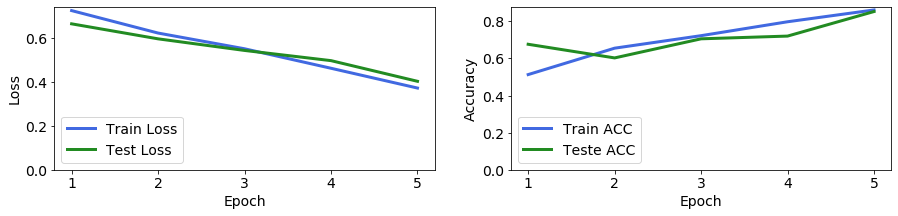

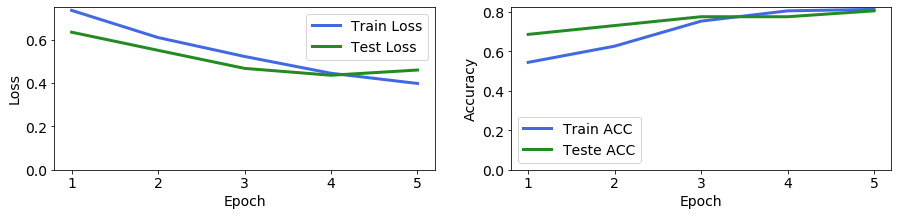

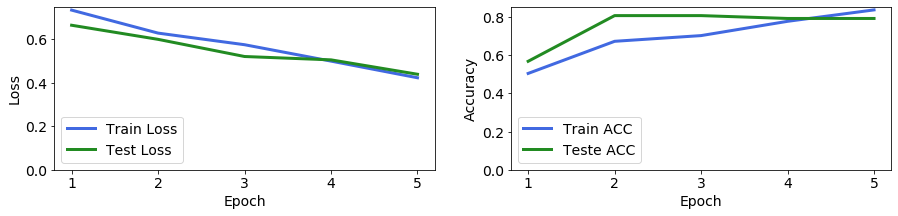

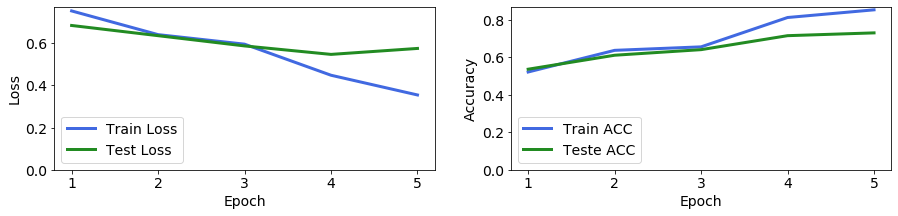

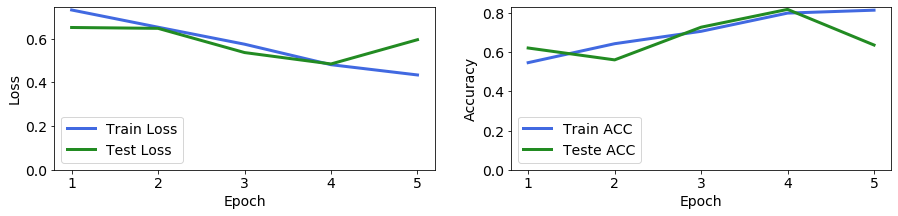

In [25]:
for hist in v_history_lstm:
    plot_acc(hist)

### Salvando Arquitetura LSTM Comum
Aqui é salvo a imagem da aquitetura da rede.

In [26]:
plot_model(lstm_model, to_file='./model/arch_img/model_lstm.png', show_shapes=True, show_layer_names=True)

## 6.2.2 -  Resultado LSTM Bidirecional

De maneira similar do resultado anterior, foi executado novamente a LSTM apenas com uma variação. Se notarmos, a rede possui a mesma estrutura da anterior, variando apenas na camada da LSTM. Neste caso o modelo é bidirecional, ou seja, em vez de percorrer a sentença em uma direção, são realizadas duas. Que podem ser nomeadas de Ida e Volta.

Dessa forma, a estrutura proposta nesta rede é a seguinte:

- Input (InputLayer)
- Embedding (Embedding)
- Lstm (LSTM Bidirecional)   
- Dense1 (Dense) com a função Sigmoid            
- Dropout1 (Dropout)                  
- Output (Dense) com a função Softmax

In [32]:
# Quantidade de épocas para serem executadas
n_epochs = 5 
# Quantidade de amostras treinadas até a atualização do gradiente
n_batch = 16 

ic_bidrec_validation = []
ic_bidrec_train = []

lstm_bidirecional_model = load_model_lstm(matrix_embedding, number_words, DIMENSION_WORD_EMBEDDING,True)

for i in range(0, 5):   
    lstm_bidirecional_model, v_history_bidrec, result_train_bidrec, result_validation_bidrec = execute_model(lstm_bidirecional_model, x_text, y_class, n_epochs, n_batch)
    
    # Salvando os resultados
    ic_bidrec_train.append(np.mean(result_train_bidrec, dtype=np.float64))
    ic_bidrec_validation.append(np.mean(result_validation_bidrec, dtype=np.float64)) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 300)               0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 300)          460800    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 600)               1442400   
_________________________________________________________________
dense1 (Dense)               (None, 20)                12020     
_________________________________________________________________
Dropout1 (Dropout)           (None, 20)                0         
_________________________________________________________________
output (Dense)               (None, 2)                 42        
Total params: 1,915,262
Trainable params: 1,454,462
Non-trainable params: 460,800
____________________________________________________________

Epoch 5/5
269/269 [==============================] - 8s 31ms/step - loss: 0.4924 - acc: 0.8067 - val_loss: 0.4491 - val_acc: 0.8333


1/5 - Folds


Train on 267 samples, validate on 68 samples
Epoch 1/5
267/267 [==============================] - 10s 37ms/step - loss: 0.7594 - acc: 0.4944 - val_loss: 0.6823 - val_acc: 0.4853
Epoch 2/5
267/267 [==============================] - 8s 31ms/step - loss: 0.6772 - acc: 0.6105 - val_loss: 0.6537 - val_acc: 0.5588
Epoch 3/5
267/267 [==============================] - 8s 31ms/step - loss: 0.6499 - acc: 0.6105 - val_loss: 0.6019 - val_acc: 0.6912
Epoch 4/5
267/267 [==============================] - 8s 31ms/step - loss: 0.5661 - acc: 0.7303 - val_loss: 0.5148 - val_acc: 0.8235
Epoch 5/5
267/267 [==============================] - 8s 31ms/step - loss: 0.4921 - acc: 0.7753 - val_loss: 0.5079 - val_acc: 0.7941


2/5 - Folds


Train on 268 samples, validate on 67 samples
Epoch 1/5
268/268 [==============================] - 8s 30ms/step - loss: 0.7387 - ac

### Resultado LSTM Bidirecional

O resultado apresentado utilizando a estrutura proposta foi de **[73.8;81]** considerando um intervalo de confiança de 95%. Se compararmos com o resultado obtido na LSTM sem a estrutura bidirecional, é possível notar que os resultados são estatisticamente semelhantes, pois os intervalos de confiança se sobrepõem. Novamente, o resultado obtido é satisfatório e comparando com outros trabalhos, não se mostram inferiores.

In [33]:
ic_bidrec_train
print("RESULTADO LSTM BIDIRECTIONAL\n")
print("Treino: {} +- {:.2}".format(calc_conf_interval(ic_bidrec_train)[0], calc_conf_interval(ic_bidrec_train)[3]))
print("Teste: {} +- {:.2}".format(calc_conf_interval(ic_bidrec_validation)[0], calc_conf_interval(ic_bidrec_validation)[3]))

RESULTADO LSTM BIDIRECTIONAL

Treino: 0.7417856854593387 +- 0.053
Teste: 0.7748330541771465 +- 0.036


### 6.2.2.1 - Gráficos LSTM Bidirecional

Abaixo temos os gráficos que correspondem a acurácia do modelo à medida que cada época é executada. Se observarmos, o modelo não sofre de overfitting devido ao acompanhamento do crescimento do teste e treino.

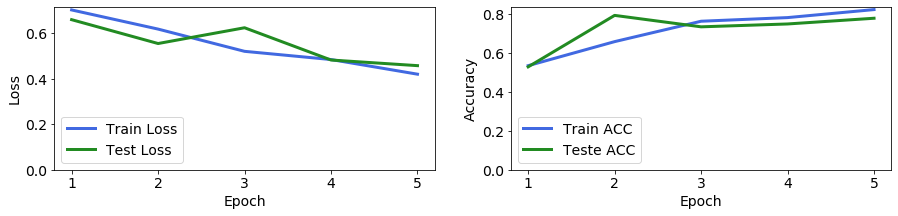

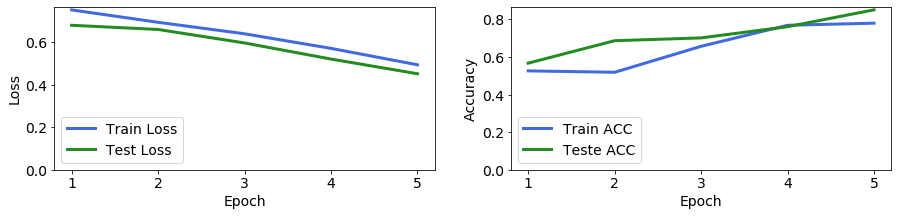

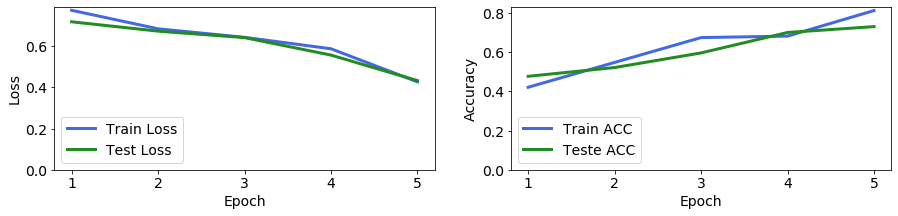

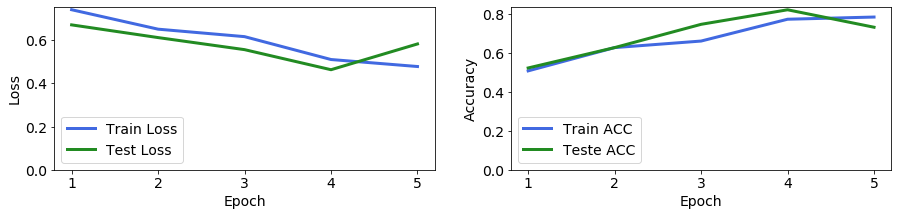

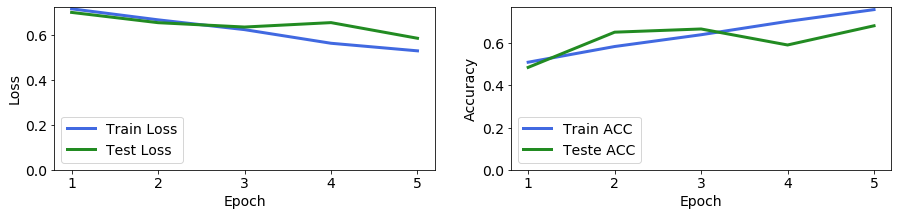

In [34]:
for hist in v_history_bidrec:
    plot_acc(hist)

### Salvando Arquitetura LSTM Bidirecional

Salva a imagem da arquitetura na pasta

In [35]:
plot_model(lstm_bidirecional_model, to_file='./model/arch_img/model_bidirec.png', show_shapes=True, show_layer_names=True)

# 6.4 - Convolutional Neural Network (CNN)

Nesta etapa implementamos a CNN 1D. A CNN tradicional é bastante utilizada para processamento de imagem, devido a alta capacidade de extração de features importantes para a detecção de objetos e classificação de imagens. Já a CNN 1D possui as mesmas camadas de convolução e pooling, só que utilizando apenas 1 dimensão. Assim sendo bastante utilizada para texto, visto que sentenças possui somente 1 dimensão.

Por fim, a estrutura da rede montada é:

- Input (InputLayer)           
- Embedding (Embedding)       
- Convolution (Conv1D)         
- Pooling (GlobalMaxPooling1D) 
- Dense_layer1 (Dense)        
- Dropout1 (Dropout)           
- Dense_layer2 (Dense)     


In [37]:
def load_model_cnn(matrix_embedding, number_words, dimmension_embedding):    
    input_shape = (SIZE_MAX_WORDS_SENTENCES,)   
    
    #Camada de Input, recebe os tweets coletados
    input_layer = Input(shape=input_shape, name="input", dtype='int32')    
    
    #Camada de Embedding com os pesos já treinados
    embedding = Embedding(number_words, dimmension_embedding, input_length=SIZE_MAX_WORDS_SENTENCES, weights=[matrix_embedding], trainable=False, name="embedding")(input_layer)
    
    #Etapa de convolução e pooling
    convolution = Conv1D(128, 5, activation='relu', name="Convolution")(embedding)
    pooling = GlobalMaxPooling1D(name="Pooling")(convolution)
    
    #Camadas densas totalmente conectadas
    dense1 = Dense(20, activation='relu', name='dense_layer1')(pooling)
    drop = layers.Dropout(0.25, name="Dropout1")(dense1)
    output_layer = Dense(2, activation='softmax', name='dense_layer2')(drop)
    
    #Criando modelo
    model_cnn = Model(input=input_layer, output=[output_layer])    
    model_cnn.summary()
    
    return model_cnn

Para a execução foi escolhido 5 épocas e um n_batch = 16, pois como não existem muitos dados, é possível calcular e corrigir os pesos mais vezes. Além disto, os parâmetros foram escolhidos após testes e validações das escolhas, concluindo que os parâmetros são os melhores para a rede.

In [38]:
ic_cnn_acc_validation = []
ic_cnn_acc_train = []

# Quantidade de épocas para serem executadas
n_epochs = 5 
# Quantidade de amostras treinadas até a atualização do gradiente
n_batch = 16 

cnn_model = load_model_cnn(matrix_embedding, number_words, DIMENSION_WORD_EMBEDDING)

#Executa 5 vezes para calcular o intervalo de confiança
for i in range(0, 5):    
    #Executando CNN
    cnn_model, v_history_cnn, result_train_cnn, result_validation_cnn = execute_model(cnn_model, x_text,
                                                                                      y_class, n_epochs, n_batch)
    # Salvando os resultados
    ic_cnn_acc_train.append(np.mean(result_train_cnn, dtype=np.float64))
    ic_cnn_acc_validation.append(np.mean(result_validation_cnn, dtype=np.float64))   
    

/usr/lib/python3/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 300)               0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 300)          460800    
_________________________________________________________________
Convolution (Conv1D)         (None, 296, 128)          192128    
_________________________________________________________________
Pooling (GlobalMaxPooling1D) (None, 128)               0         
_________________________________________________________________
dense_layer1 (Dense)         (None, 20)                2580      
_________________________________________________________________
Dropout1 (Dropout)           (None, 20)                0         
_________________________________________________________________
dense_layer2 (Dense)         (None, 2)                 42        
Total para

268/268 [==============================] - 0s 2ms/step - loss: 0.6915 - acc: 0.5970 - val_loss: 0.5812 - val_acc: 0.6269
Epoch 2/5
268/268 [==============================] - 0s 2ms/step - loss: 0.3430 - acc: 0.8545 - val_loss: 0.4439 - val_acc: 0.8060
Epoch 3/5
268/268 [==============================] - 0s 2ms/step - loss: 0.1863 - acc: 0.9403 - val_loss: 0.4692 - val_acc: 0.8209
Epoch 4/5
268/268 [==============================] - 0s 2ms/step - loss: 0.1314 - acc: 0.9627 - val_loss: 0.4495 - val_acc: 0.8209
Epoch 5/5
268/268 [==============================] - 0s 2ms/step - loss: 0.0770 - acc: 0.9664 - val_loss: 0.4880 - val_acc: 0.8209


3/5 - Folds


Train on 268 samples, validate on 67 samples
Epoch 1/5
268/268 [==============================] - 0s 2ms/step - loss: 0.6937 - acc: 0.5933 - val_loss: 0.6283 - val_acc: 0.6716
Epoch 2/5
268/268 [==============================] - 0s 2ms/step - loss: 0.4401 - acc: 0.7761 - val_loss: 0.5766 - val_acc: 0.7612
Epoch 3/5
268/268 [=============

### 6.4.1 - Resultado CNN

Novamente a rede apresentou resultados satisfatórios **[78.8;87.4]** considerando um intervalo de confiança de 95%. Se observarmos os resultados comparando com a LSTM por exemplo, observa-se que os resultados são estatisticamente similares. Mesmo assim, a CNN se mostrou uma boa rede para tarefa, superando os outros modelos em tempo de execução. Com isso, podemos afirmar que ambas as redes apresentam bons resultados e se mostram eficientes para o problema.

In [39]:
print("RESULTADOS CNN\n")
print("Treino: {} +- {:.2}".format(calc_conf_interval(ic_cnn_acc_train)[0], calc_conf_interval(ic_cnn_acc_train)[3]))
print("Teste: {} +- {:.2}".format(calc_conf_interval(ic_cnn_acc_validation)[0], calc_conf_interval(ic_cnn_acc_validation)[3]))

RESULTADOS CNN

Treino: 0.9280599075161124 +- 0.075
Teste: 0.8311461410597435 +- 0.043


### 6.4.1.2 - Gráficos CNN

Abaixo temos os gráficos que representam a execução do modelo em diferentes épocas. Nota-se que a medida que a quantidade de épocas aumenta a acurácia cresce e a perda diminui. Além disto, o modelo não sofre do overfitting devido ao crescimento tanto no teste quanto no treino.

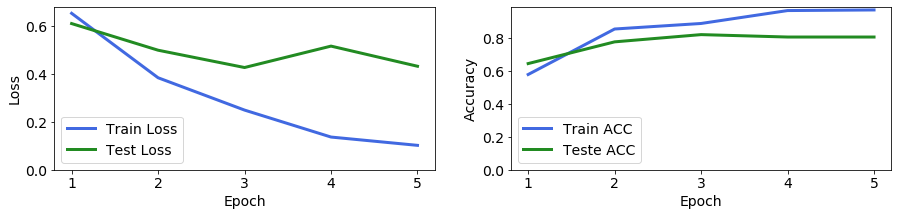

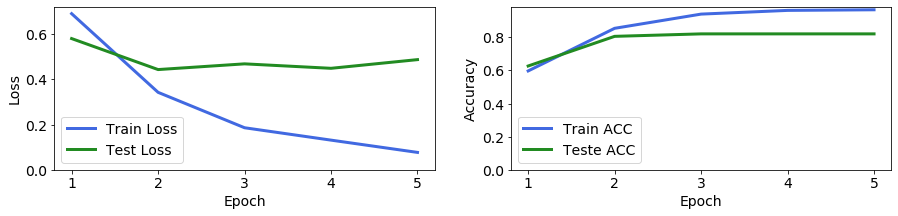

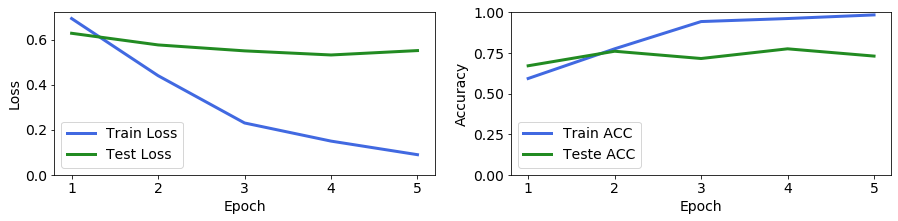

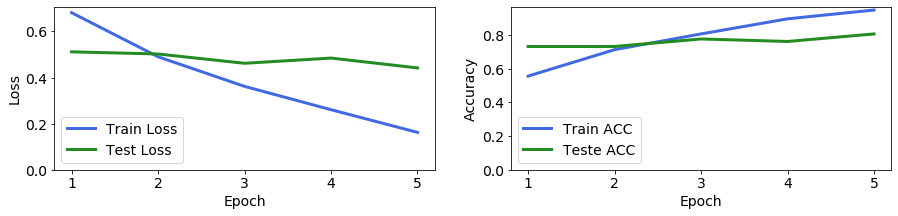

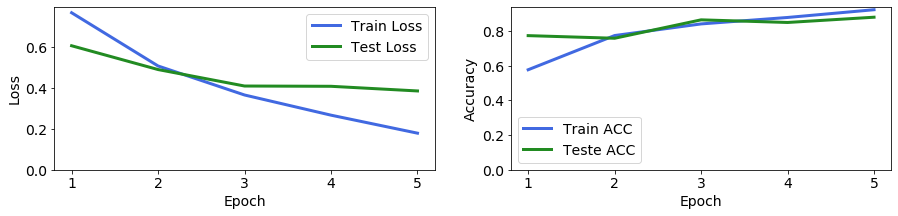

In [40]:
for hist in v_history_cnn:
    plot_acc(hist)

## Salvando arquitetura CNN

Salvando imagem da arquitetura da rede.

In [41]:
plot_model(cnn_model, to_file='./model/arch_img/model_cnn.png', show_shapes=True, show_layer_names=True)

# Conclusão

Ao todo no trabalho foram implementados 4 algoritmos, sendo eles: Regressão Logística, LSTM, LSTM Bidirecional e CNN.

- Regression Logistic [83.3;85.9]
- CNN  [78.8;87.4]
- LSTM [75.6;82]
- LSTM Bidirecional [73.8;81]


- Se observarmos os resultados individualmente, notamos que o Regression Logistic e CNN estão empatados estatisticamente. Já LSTM e a LSTM bidirecional também apresentam resultados similares com base no intervalo de confiança apresentado.


- Além disto, a regressão logística se mostrou eficiente, indicando que um modelo simples pode conseguir bons resultados. Isso evidencia que o problema a ser resolvido não tão complexo e os padrões existente nos textos são simples. Dessa forma um modelo simples atinge bons resultados se equiparando a modelos mais complexos.


- Em complemento, os resultados conquistados podem ter sido afetados devido às etapas de processamento e também pela pouca quantidade de dados. Em linhas gerais, as redes neurais necessitam de bastante dados para treinamento e teste. Mesmo apresentando bons resultados em poucos dados, os modelos poderiam alcançar resultados superiores se treinados com dados mais variados, por exemplo.


- O processamento dos dados é outro fator importante. Como foi utilizado palavras-chaves e entidades, foi inserido viés nos dados, sendo que a grande maioria possui estruturas similares e possuem as entidades coletadas. Além disto, por se tratar do Twitter, a grande maioria das sentenças são curtas, então após a remoção das stopwords e entidades, algumas sentenças se tornam bastante pobres. Com isso, os modelos podem encontrar problemas para classificá-las. Por exemplo, "Pepsi é melhor do que Coca-Cola" após o processamento ficaria somente "é melhor". Essas fracas estruturas podem afetar os modelos mais complexos, que precisam encontrar características nas sentenças para a classificação.


- Mesmo com todos os problemas apresentados os modelos apresentaram resultados equivalentes ao estado da arte. Sendo assim, podemos afirmar que o trabalho é uma grande contribuição para o avanço de outros estudos no português.


Por fim, os modelos se apresentaram resultados satisfatórios e condizentes com o estado da arte, que apresenta resultados similares.

# Trabalhos Futuros - LSTM com Attention

Nesta parte do trabalho, foi tentado utilizar a LSTM utilizando o Attention. O attention se traduzido para o português seria atenção. De fato, a ideia é fazer com que o modelo dê atenção apenas para as partes importantes para a classificação das sentenças. No contexto do trabalho, provavelmente a rede daria um maior foco em palavras como: melhor, bem, superior, pois geralmente essas palavras podem indicar a existência de comparação em sentenças.

A arquitetura da rede é similar a LSTM tradicional, apenas são adicionados algumas camadas extras. A saída da camada LSTM é entrada para as etapas de attention, que adiciona um peso maior para as palavras com base na sua importância. Após isso, a saída das camadas de attention é multiplicada pela saída original da LSTM e enviada para a camada totalmente conectada. Com essa abordagem, o modelo pode inferir quais palavras foram importantes dando uma maior importância para sua ocorrência.

**Em complemento no trabalho, iniciou-se o desenvolvimento do modelo LSTM com Attention. A rede foi totalmente implementada, mas devido um problema encontrado próximo a data de submissão, inviabilizou a execução da rede novamente, pois era necessário testar novos parâmetros e regularizadores. Dessa forma, a rede abaixo implementa toda a rede mas seus resultados não são apresentados nem discutidos por este motivo.**

In [42]:
def load_lstm_attention(matrix_embedding, number_words, dimmension_embedding):
    input_shape = (SIZE_MAX_WORDS_SENTENCES,)   
    
    #Camada de Input, recebe os tweets coletados
    input_layer = Input(shape=input_shape, name="input", dtype='int32')    
  
    #Camada de Embedding com os pesos já treinados
    embedding = Embedding(number_words, dimmension_embedding, input_length=SIZE_MAX_WORDS_SENTENCES, name="embedding",  weights=[matrix_embedding], trainable=False)(input_layer)
    
    #Cria o modelo LSTM Bidirecional
    lstm = LSTM(dimmension_embedding, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, name="lstm_bidirectional")(embedding)
    
    #Constuindo a parte do attention.      
    attention = Dense(1, activation='tanh')(lstm)
    attention = Flatten()(attention)
    attention = Activation('softmax', name='attention_vec')(attention)
    attention = RepeatVector(dimmension_embedding)(attention)
    attention = Permute([2, 1])(attention)
    
    #Multiplica os pesos da camada anterior com a saída da LSTM (A parte que a rede presta "atenção")
    sent_representation = layers.Multiply()([lstm, attention])
    sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(dimmension_embedding,))(sent_representation)
        
    #Camada totalmente conectada, com saída = 2. A saída indica a probabilidade do texto ser de cada classe
    output_layer = Dense(2, activation='sigmoid', name='output')(sent_representation)
   
    #Cria o modelo
    model = Model(input=input_layer, output=[output_layer])    
    model.summary()
    
    return model  

Abaixo é possível visualizar a arquitetura da rede implementada. 

In [43]:
model_attention = load_lstm_attention(matrix_embedding, number_words, DIMENSION_WORD_EMBEDDING)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 300)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 300)     460800      input[0][0]                      
__________________________________________________________________________________________________
lstm_bidirectional (LSTM)       (None, 300, 300)     721200      embedding[0][0]                  
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300, 1)       301         lstm_bidirectional[0][0]         
__________________________________________________________________________________________________
flatten_1 

/usr/lib/python3/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


In [45]:
plot_model(model_attention, to_file='./model/arch_img/model_attention.png', show_shapes=True, show_layer_names=True)